In [1]:
import numpy as np
import torch
from baselines.cifar10_loader import load_and_process_cifar
from models.classifier import MLP
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F
#torch.set_float32_matmul_precision('medium')
%load_ext autoreload
%autoreload 2

In [2]:
class CoolDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        i = self.labels[idx]
        l = torch.zeros(size=(10,))
        l[i] = 1
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long).squeeze(-1)#l

In [57]:
dct = load_and_process_cifar(n_components=20, return_all=True)

PCA explained variance ratio:  1.0


In [58]:

x_train, x_val, x_test, x_test_ood =  dct['x_train'], dct['x_val'], dct['x_test'], dct['x_test_ood']
y_train, y_val, y_test, y_test_ood =  dct['y_train'], dct['y_val'], dct['y_test'], dct['y_test_ood']


In [60]:
base_model = MLP(input_size=20,
    hidden_layers=[32, 32],
    output_size=10,
    dropout=0.5,
    logger='auc', loss='ce',
    loss_params=None, optim='adam',
    optim_params=dict(lr=1e-4, weight_decay=0),
    scheduler=None,
    scheduler_params=None,
    legacy=True,
)

In [62]:
batch_size = 64
learning_rate = 1e-4
epochs=20

In [63]:
trainer = pl.Trainer(
    limit_train_batches=100,
    max_epochs=epochs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [64]:
train_loader = DataLoader(CoolDataset(x_train, y_train), batch_size=batch_size, num_workers=20)
val_loader = DataLoader(CoolDataset(x_val, y_val), batch_size=batch_size, num_workers=20)
test_loader = DataLoader(CoolDataset(x_test, y_test), batch_size=batch_size, num_workers=20)
ood_test_loader = DataLoader(CoolDataset(x_test_ood, y_test_ood), batch_size=batch_size, num_workers=20)

In [65]:
trainer.fit(base_model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 2.1 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
2 | _logger | AUCLogger        | 0      | train
-----------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [69]:
trainer.save_checkpoint('pddm_cifar10.pth')

In [70]:
model2 = MLP.load_from_checkpoint('pddm_cifar10.pth', input_size=20,
    hidden_layers=[32, 32],
    output_size=10,
    dropout=0.5,
    logger='auc', loss='ce',
    loss_params=None, optim='adam',
    optim_params=dict(lr=1e-3, weight_decay=0),
    scheduler=None,
    scheduler_params=None,
    legacy=True)

In [75]:
# sanity check

def evaluate(model, loader):
    model.eval()
    model = model.cuda()
    count = 0
    acc = 0 
    for features, labels in loader:
        features, labels = features.cuda(), labels.cuda()
        logits = model(features)
        output = F.softmax(logits, dim=-1)
        preds = torch.argmax(output, dim=-1)
        acc += torch.sum(preds == labels)
        count += len(labels)
    return acc / count

In [78]:
evaluate(model2, train_loader)

tensor(0.9008, device='cuda:0')

In [250]:
import pickle

def save_dataset(dataset, name):
    with open(name, 'wb') as f:
        pickle.dump(dataset, f)

In [251]:
dct = {
    'x_train1': x_train1,
    'x_train2': x_train2,
    'x_val': x_val,
    'x_test': x_test,
    'y_train1':y_train1,
    'y_train2': y_train2,
    'y_val': y_val,
    'y_test': y_test
}

In [252]:
save_dataset(dct, 'pddm_cifar10.pkl')

In [253]:
with open('pddm_cifar10.pkl', 'rb') as f:
    dct = pickle.load(f)

## CIFAR 10.1 PDDM

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import sklearn
from tqdm import tqdm 
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
alpha = 2
batch_size = 64
learning_rate = 1e-4
epochs=10

In [3]:

def load_cifars():
    tmp = {}
    splits = ['train', 'val', 'test']
    kk = ['x', 'y']
    # load iid 
    for k in kk:
        for split in splits:
            with open('baselines/data/cifar10_' + k + '_' + split + '.npy', 'rb') as f:
                tmp[k + '_' + split] = np.load(f)
    
    with open('baselines/data/cifar101_x_test.npy', 'rb') as f:
                tmp['x_test_ood'] = np.load(f)
    with open('baselines/data/cifar10.1_v6_labels.npy', 'rb') as f:
                tmp['y_test_ood'] = np.load(f)
    tmp['x_test_ood'], tmp['y_test_ood'] = sklearn.utils.shuffle(tmp['x_test_ood'], tmp['y_test_ood'])
    return tmp
    # load ood
dct = load_cifars()

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, sample_weights=None):
        self.features = features
        self.labels = labels
        self.sample_weights = sample_weights
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.sample_weights[idx] if self.sample_weights is not None else torch.tensor(1)

def dce_loss(logits: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor, alpha=None,
             use_random_vectors=False, weight=None) -> torch.Tensor:
    if mask.all():
        # if all labels are positive, then use the standard cross entropy loss
        return F.cross_entropy(logits, labels)

    if alpha is None:
        alpha = 1 / (1 + (~mask).float().sum())

    num_classes = logits.shape[1]

    q_logits, q_labels = logits[~mask], labels[~mask]
    if use_random_vectors:
        # noinspection PyTypeChecker,PyUnresolvedReferences
        p = - torch.log(torch.rand(device=q_labels.device, size=(len(q_labels), num_classes)))
        p *= (1. - F.one_hot(q_labels, num_classes=num_classes))
        p /= torch.sum(p)
        ce_n = -(p * q_logits).sum(1) + torch.logsumexp(q_logits, dim=1)

    else:
        zero_hot = 1. - F.one_hot(q_labels, num_classes=num_classes)
        ce_n = -(q_logits * zero_hot).sum(dim=1) / (num_classes - 1) + torch.logsumexp(q_logits, dim=1)

    if torch.isinf(ce_n).any() or torch.isnan(ce_n).any():
        raise RuntimeError('NaN or Infinite loss encountered for ce-q')

    if (~mask).all():
        return (ce_n * alpha).mean()

    p_logits, p_labels = logits[mask], labels[mask]
    ce_p = F.cross_entropy(p_logits, p_labels, reduction='none', weight=weight)
    return torch.cat([ce_n * alpha, ce_p]).mean()

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim=20, hid_dim=32, out_dim=10, p=0.2):
        super(Net, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.p = p
    
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.fc2 = nn.Linear(self.hid_dim, self.hid_dim)
        self.fc3 = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.fc1(x)), p=self.p)
        x = F.dropout(F.relu(self.fc2(x)), p=self.p)
        return self.fc3(x)

class MLP_Model:
    def __init__(self, in_dim, hid_dim, out_dim, p, batch_size, train_epochs, learning_rate, alpha=2):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #print('Running neural nets on {}'.format(self.device))
        self.net = Net(in_dim, hid_dim, out_dim, p)
        self.net = self.net.to(self.device)
        self.batch_size = batch_size
        self.train_epochs = train_epochs
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        self.criterion = dce_loss
        self.alpha = alpha
        
    def train_disagreement(self, x, y, sample_weights=None):
        model = self.net
        model.train()
        train_loader = self._create_dataloader(x, y, sample_weights=sample_weights)
        for e in tqdm(range(epochs)):
            for features, labels, sample_weights in train_loader:
                features, labels, sample_weights = features.to(device), labels.to(device), sample_weights.to(device)
                output = model(features)
                self.optimizer.zero_grad()
                mask = (sample_weights == torch.ones_like(sample_weights)).squeeze(-1)
                loss = self.criterion(output, labels, mask, self.alpha)
                loss.backward()
                self.optimizer.step()
    
    def train_base_model(self, x, y):
        model = self.net
        model.train()
        train_loader = self._create_dataloader(x, y)
        for e in tqdm(range(epochs)):
            for features, labels, sample_weights in train_loader:
                features, labels, sample_weights = features.to(device), labels.to(device), sample_weights.to(device)
                output = model(features)
                self.optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(output, labels)
                loss.backward()
                self.optimizer.step()
                
    def evaluate_model(self, x, y):
        model = self.net
        model.eval()
        correct = 0
        total = 0
        loader = self._create_dataloader(x, y)
        with torch.no_grad():
            for features, labels, sample_weights in loader:
                features, labels, sample_weights = features.to(device), labels.to(device), sample_weights.to(device)
                output = F.softmax(model(features), dim=1)
                preds = torch.argmax(output, dim=1)
                correct += torch.sum(preds == labels).item()
                total += len(labels)
                
        return correct/total
            
        
    def _create_dataloader(self, features, labels, sample_weights=None):
        features, labels = torch.as_tensor(features, dtype=torch.float32), torch.as_tensor(labels)
        if sample_weights is not None:
            sample_weights = torch.as_tensor(sample_weights)
        dataset = CustomDataset(features, labels, sample_weights=sample_weights)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)
        return dataloader
    
    def get_labels(self, x):
        self.net.eval()
        probas = F.softmax(self.net(x), dim=1)
        preds = torch.argmax(probas, dim=1)
        preds = preds.detach().cpu().numpy()
        return preds

In [6]:
x_train, x_val, x_test, x_test_ood =  dct['x_train'], dct['x_val'], dct['x_test'], dct['x_test_ood']
y_train, y_val, y_test, y_test_ood =  dct['y_train'], dct['y_val'], dct['y_test'], dct['y_test_ood']

In [7]:
trainset = CustomDataset(x_train, y_train)
valset = CustomDataset(x_val, y_val)
testset = CustomDataset(x_test, y_test)
testset_ood = CustomDataset(x_test_ood, y_test_ood, torch.ones(size=y_test_ood.shape) * alpha)

In [8]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=20)
val_loader = DataLoader(valset, batch_size=64, shuffle=True, num_workers=20)
test_loader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=20)
test_ood_loader = DataLoader(testset_ood, batch_size=64, shuffle=True, num_workers=20)

In [9]:
base_model = MLP_Model(20,32, 10, 0.2, 64, 10, 1e-4)
base_model.train_base_model(x_train, y_train)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [11]:
base_model.evaluate_model(x_train, y_train)

0.88145

In [12]:
base_preds = base_model.get_labels(torch.as_tensor(x_val, dtype=torch.float32).cuda())

In [13]:
x_merged = np.concatenate([x_train, x_val], axis=0)
y_merged = np.concatenate([y_train, base_preds], axis=0)
sample_weights = np.ones(shape=(len(x_train) + len(x_val), 1))
sample_weights[len(x_train):] = sample_weights[len(x_train):] * alpha

In [14]:
new_net = MLP_Model(20,32, 10, 0.2, 64, 10, 1e-4)

In [15]:
optimizer = optim.Adam(new_net.net.parameters(), lr=1e-4)
def _create_dataloader(features, labels, sample_weights=None):
        features, labels = torch.as_tensor(features, dtype=torch.float32), torch.as_tensor(labels)
        if sample_weights is not None:
            sample_weights = torch.as_tensor(sample_weights)
        dataset = CustomDataset(features, labels, sample_weights=sample_weights)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)
        return dataloader
    
def train_disagreement(model, x, y, optimizer, sample_weights=None, alpha=10):
        model.train()
        train_loader = _create_dataloader(x, y, sample_weights=sample_weights)
        for e in tqdm(range(epochs)):
            for features, labels, sample_weights in train_loader:
                features, labels, sample_weights = features.to(device), labels.to(device), sample_weights.to(device)
                output = model(features)
                optimizer.zero_grad()
                mask = (sample_weights == torch.ones_like(sample_weights)).squeeze(-1)
                loss = dce_loss(output, labels, mask, alpha)
                loss.backward()
                optimizer.step()

In [265]:
new_net = MLP_Model(20,32, 10, 0.2, 64, 10, 1e-4)
optimizer = optim.AdamW(new_net.net.parameters(), lr=1e-4)
train_disagreement(new_net.net, x_merged, y_merged, optimizer, sample_weights, 30)
a = new_net.evaluate_model(x_train, y_train)
b = new_net.evaluate_model(x_val, y_val)
print(a, b)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


0.64905 0.5721


In [16]:
def algo1(base_model:MLP_Model, data, rounds=100, alpha=30):
    x_train, x_val, y_train, y_val = data
    base_preds = base_model.get_labels(torch.as_tensor(x_val, dtype=torch.float32).cuda())
    Phi = []
    for i in tqdm(range(rounds)):
        new_model = MLP_Model(20,32, 4, 0.2, 64, 10, 1e-4, alpha=alpha)
        id_val = np.random.choice(len(x_val), len(x_val), replace=True)
        xx, yy = x_val[id_val], base_preds[id_val]
        x_merged = np.concatenate([x_train, xx], axis=0)
        y_merged = np.concatenate([y_train, yy], axis=0)
        #x_merged = np.concatenate([x_train, x_val], axis=0)
        #y_merged = np.concatenate([y_train, base_preds], axis=0)
        
        sample_weights = np.ones(shape=(len(x_train) + len(xx), 1))
        sample_weights[len(x_train):] = sample_weights[len(x_train):] * 2
        new_model.train_disagreement(x_merged, y_merged, sample_weights)
        dis = 1 - ((new_model.get_labels(torch.as_tensor(x_val, dtype=torch.float32).cuda()) == yy).sum() / len(x_val))
        print(dis)
        Phi.append(dis)
    return Phi

def algo2(base_model, data, Phi, alpha=30): 
    (x_train, x_val, y_train, y_val) = data
    base_preds = base_model.get_labels(torch.as_tensor(x_val, dtype=torch.float32).cuda())
    
    new_model = MLP_Model(20,32, 4, 0.2, 64, 10, 1e-4, alpha=alpha)
    id_val = np.random.choice(len(x_val), len(x_val), replace=True)
    xx, yy = x_val[id_val], base_preds[id_val]
    #x_merged = np.concatenate([x_train, xx], axis=0)
    #y_merged = np.concatenate([y_train, yy], axis=0)
    x_merged = np.concatenate([x_train, x_val], axis=0)
    y_merged = np.concatenate([y_train, base_preds], axis=0)
    
    sample_weights = np.ones(shape=(len(x_train) + len(xx), 1))
    sample_weights[len(x_train):] = sample_weights[len(x_train):] * 2
    new_model.train_disagreement(x_merged, y_merged, sample_weights)
    dis = 1 - ((new_model.get_labels(torch.as_tensor(x_val, dtype=torch.float32).cuda()) == yy).sum() / len(x_val))
    print(dis)
    return dis
    
    
    

In [17]:
Phi = algo1(base_model, (x_train, x_val, y_train, y_val), rounds=10, alpha=2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [5,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [10,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [11,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKe

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [35]:
algo2(base_model, (x_train, x_val, y_train, y_val), Phi, alpha=2)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

0.8995


0.8995

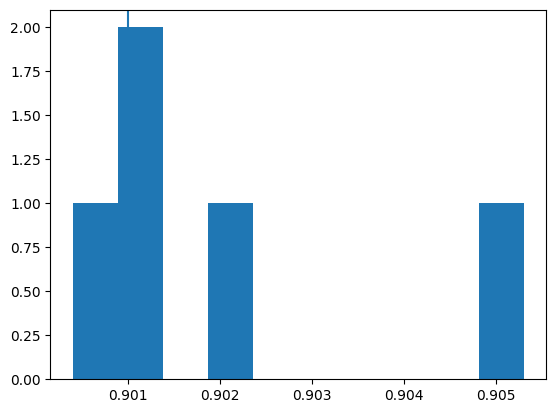

In [30]:
import matplotlib.pyplot as plt
plt.hist(Phi)
plt.axvline(0.901)